In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
!nvidia-smi

Wed Jul 20 14:35:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!wget https://raw.githubusercontent.com/Illalla/helper_functions_for_tf/main/helper_functions.py
from helper_functions import *

--2022-07-20 14:35:08--  https://raw.githubusercontent.com/Illalla/helper_functions_for_tf/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6556 (6.4K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]   6.40K  --.-KB/s    in 0s      

2022-07-20 14:35:08 (85.6 MB/s) - ‘helper_functions.py.1’ saved [6556/6556]



https://arxiv.org/abs/1710.06071

In [5]:
## Getting data

!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [6]:
!ls /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [7]:
# Experiments on 20k with @
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign'

In [8]:
# Creating file directories
import os
filedirs = [data_dir + '/' + filename for filename in os.listdir(data_dir)]

In [9]:
filedirs

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocessing

In [10]:
def get_lines(filename):
  """
  Reads filename and returns the lines of text as a list.
  """

  with open(filename, 'r') as f:
    return f.readlines()

In [11]:
get_lines(filedirs[0])[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [12]:
def preprocess_abstracts(filenames):
  """Takes filenames and returns lists of dictionaries containing line number, target, text and total lines"""
  lines = get_lines(filenames)
  abstract_samples = []
  abstract_lines = ''


  for line in lines:
    if line.startswith('###'):
      id = line[:-1]
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()
      abstract_lines = ''
      
      for i, a in enumerate(abstract_line_split):
        split = a.split('\t')
        total_lines = len(abstract_line_split)-1
        abstract_samples.append({'id': id,
                                 'line_number': i,
                                 'target': split[0],
                                 'text': split[1],
                                 'total_lines': total_lines})
    else:
      abstract_lines += line
  return abstract_samples

In [13]:
filedirs

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

In [14]:
%%time
for filedir in filedirs:
  if 'train' in filedir:
    training_set = preprocess_abstracts(filedir)
  if 'test' in filedir:
    test_set = preprocess_abstracts(filedir)
  else:
    val_set = preprocess_abstracts(filedir)


CPU times: user 620 ms, sys: 156 ms, total: 777 ms
Wall time: 813 ms


In [15]:
training_set[10000:50000]

[{'id': '###24393610',
  'line_number': 0,
  'target': 'BACKGROUND',
  'text': 'Evidence is often missing on social differentials in effects of nutrition interventions .',
  'total_lines': 11},
 {'id': '###24393610',
  'line_number': 1,
  'target': 'BACKGROUND',
  'text': 'We evaluated the adherence to and effect of prenatal food and micronutrient supplementations on mortality before the age of five years in different social groups as defined by maternal schooling .',
  'total_lines': 11},
 {'id': '###24393610',
  'line_number': 2,
  'target': 'METHODS',
  'text': 'Data came from the MINIMat study ( Maternal and Infant Nutrition Interventions , Matlab ) , a randomized trial of prenatal food supplementation ( invitation early , about @ weeks -LSB- E -RSB- , or at usual time , about @ weeks -LSB- U -RSB- of pregnancy ) and @mg or @mg iron with @ gm folic acid , or multiple micronutrients ( Fe@F , Fe@F , MMS ) resulting in six randomization groups , EFe@F , UFe@F , EFe@F , UFe@F , EMMS , 

In [16]:
train_df = pd.DataFrame(training_set)
val_df = pd.DataFrame(val_set)
test_df = pd.DataFrame(test_set)

In [17]:
train_df.head(10)

,id,line_number,target,text,total_lines
0,###24293578,0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,11
1,###24293578,1,METHODS,A total of @ patients with primary knee OA wer...,11
2,###24293578,2,METHODS,Outcome measures included pain reduction and i...,11
3,###24293578,3,METHODS,Pain was assessed using the visual analog pain...,11
4,###24293578,4,METHODS,Secondary outcome measures included the Wester...,11
5,###24293578,5,METHODS,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",11
6,###24293578,6,RESULTS,There was a clinically relevant reduction in t...,11
7,###24293578,7,RESULTS,The mean difference between treatment arms ( @...,11
8,###24293578,8,RESULTS,"Further , there was a clinically relevant redu...",11
9,###24293578,9,RESULTS,These differences remained significant at @ we...,11


In [18]:
dict(train_df.value_counts('target')).values()

dict_values([59353, 57953, 27168, 21727, 13839])

<BarContainer object of 5 artists>

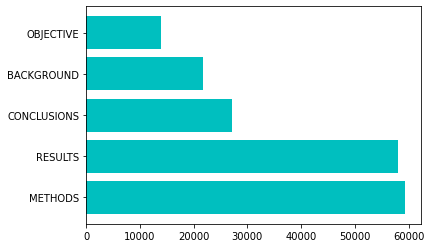

In [19]:
plt.barh(list(dict(train_df.value_counts('target')).keys()), dict(train_df.value_counts('target')).values(), color='c')

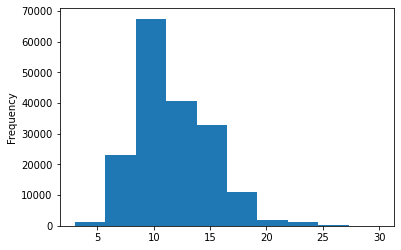

In [20]:
train_df.total_lines.plot.hist();

In [21]:
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

In [22]:
train_sentences[:5]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .']

In [23]:
# One hot encoding labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = tf.constant(one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1)))
val_labels_one_hot = tf.constant(one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1)))
test_labels_one_hot = tf.constant(one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1)))
train_labels_one_hot, train_labels_one_hot.shape

(<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
 array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]])>, TensorShape([180040, 5]))

In [24]:
train_df['target'].to_numpy().reshape(-1, 1).shape

(180040, 1)

In [25]:
# Extract labels and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

In [26]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [27]:
class_names = label_encoder.classes_
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [28]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

model_0 = Pipeline([
                    ('tfidf', TfidfVectorizer()),
                    ('clf', MultinomialNB())
                    ])

model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [29]:
from sklearn.metrics import recall_score, f1_score, precision_score, accuracy_score
def classification_scores(y_true, y_preds, average='weighted'):
  """Shows accuracy, precision, recall and f1-score""" 

  print(f"""Accuracy: {accuracy_score(y_true, y_preds)}
Precision: {precision_score(y_true, y_preds, average=average)}
Recall: {recall_score(y_true, y_preds, average=average)}
F1_score: {f1_score(y_true, y_preds, average=average)}""")

In [30]:
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [31]:
baseline_scores = classification_scores(val_labels_encoded, model_0.predict(val_sentences), average='weighted')
baseline_scores

Accuracy: 0.7218323844829869
Precision: 0.7186466952323352
Recall: 0.7218323844829869
F1_score: 0.6989250353450294


In [32]:
sentence_lengths = [len(sentence.split()) for sentence in train_sentences]
np.mean(sentence_lengths), np.max(sentence_lengths)

(26.338269273494777, 296)

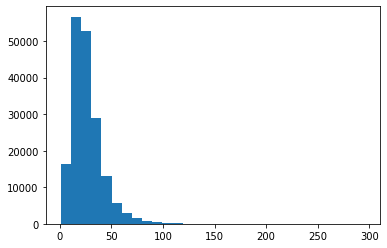

In [33]:
plt.hist(sentence_lengths, bins=30);

In [34]:
np.percentile(sentence_lengths, 95)

55.0

In [35]:
from tensorflow.keras.layers import TextVectorization, Embedding

max_tokens = 100000
max_length = 55

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    split='whitespace',
                                    pad_to_max_tokens=True,
                                    output_sequence_length=max_length)
text_vectorizer.adapt(train_sentences)

In [36]:
vocab = text_vectorizer.get_vocabulary()
vocab[:10]

['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']

In [37]:
embedding = Embedding(max_tokens,
          output_dim=128,
          input_length=len(vocab),
          mask_zero=True)

In [38]:
# Making tf.datasets

In [39]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset, len(val_dataset)

(<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 945)

In [40]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=3, padding='same')(x)
x = layers.Conv1D(filters=64, kernel_size=3, padding='same')(x)
x = layers.Conv1D(filters=32, kernel_size=3, padding='same')(x)
x = layers.MaxPool1D()(x)
x = layers.Conv1D(filters=32, kernel_size=3, padding='same')(x)
x = layers.Conv1D(filters=8, kernel_size=3, padding='same')(x)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(5, activation='softmax')(x)

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
history_1 = model_1.fit(train_dataset, epochs=5, validation_data=val_dataset, steps_per_epoch=int(0.1*len(train_dataset)), validation_steps=len(val_dataset), callbacks=[create_tb_callback('model_1_batches', 'experiments')])

Epoch 1/5
562/562 [==============================] - 21s 17ms/step - loss: 1.2991 - accuracy: 0.4672 - val_loss: 1.0006 - val_accuracy: 0.6107
Epoch 2/5
562/562 [==============================] - 9s 16ms/step - loss: 0.8941 - accuracy: 0.6575 - val_loss: 0.7640 - val_accuracy: 0.7106
Epoch 3/5
562/562 [==============================] - 9s 16ms/step - loss: 0.7246 - accuracy: 0.7259 - val_loss: 0.6821 - val_accuracy: 0.7470
Epoch 4/5
562/562 [==============================] - 9s 16ms/step - loss: 0.6680 - accuracy: 0.7511 - val_loss: 0.6478 - val_accuracy: 0.7579
Epoch 5/5
562/562 [==============================] - 9s 16ms/step - loss: 0.6586 - accuracy: 0.7561 - val_loss: 0.6281 - val_accuracy: 0.7680


In [41]:
model_1_scores = classification_scores(val_labels_one_hot, tf.round(model_1.predict(val_dataset)))
model_1_scores

Accuracy: 0.7058122600291274
Precision: 0.8093853550558172
Recall: 0.7058122600291274
F1_score: 0.7474948550643905


## Glove Embeddings 
- https://keras.io/examples/nlp/pretrained_word_embeddings/

In [42]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-07-20 14:36:59--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-07-20 14:37:00--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-07-20 14:37:00--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

gl

In [43]:
word_index = dict(zip(vocab, range(len(vocab))))

In [44]:

embeddings_index = {}
with open('/content/glove.6B.100d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [45]:
num_tokens = len(vocab) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 29730 words (35111 misses)


In [46]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [47]:
inputs = tf.keras.Input(shape=(1,), dtype=tf.string)
int_sequences = text_vectorizer(inputs)
embedded_sequences = embedding_layer(int_sequences)
x = layers.Conv1D(filters=64, kernel_size=3, padding='same')(embedded_sequences)
x = layers.Conv1D(filters=64, kernel_size=3, padding='same')(x)
x = layers.Conv1D(filters=32, kernel_size=3, padding='same')(x)
x = layers.MaxPool1D()(x)
x = layers.Conv1D(filters=32, kernel_size=3, padding='same')(x)
x = layers.Conv1D(filters=8, kernel_size=3, padding='same')(x)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(5, activation='softmax')(x)
preds = layers.Dense(len(class_names), activation="softmax")(x)
model_2 = tf.keras.Model(inputs, preds)
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 55, 100)           6484300   
                                                                 
 conv1d_5 (Conv1D)           (None, 55, 64)            19264     
                                                                 
 conv1d_6 (Conv1D)           (None, 55, 64)            12352     
                                                                 
 conv1d_7 (Conv1D)           (None, 55, 32)            6176      
                                                           

In [48]:
model_2.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
history_2 = model_2.fit(train_dataset, epochs=5, validation_data=val_dataset, steps_per_epoch=int(0.1*len(train_dataset)), validation_steps=len(val_dataset), callbacks=[create_tb_callback('model_2(glove)', 'experiments')])

Epoch 1/5
562/562 [==============================] - 6s 10ms/step - loss: 1.2312 - accuracy: 0.4967 - val_loss: 1.0257 - val_accuracy: 0.6003
Epoch 2/5
562/562 [==============================] - 5s 9ms/step - loss: 0.9533 - accuracy: 0.6280 - val_loss: 0.9165 - val_accuracy: 0.6481
Epoch 3/5
562/562 [==============================] - 5s 9ms/step - loss: 0.8782 - accuracy: 0.6616 - val_loss: 0.8401 - val_accuracy: 0.6790
Epoch 4/5
562/562 [==============================] - 5s 9ms/step - loss: 0.8297 - accuracy: 0.6787 - val_loss: 0.8030 - val_accuracy: 0.6947
Epoch 5/5
562/562 [==============================] - 5s 9ms/step - loss: 0.8171 - accuracy: 0.6927 - val_loss: 0.7804 - val_accuracy: 0.7053


In [49]:
model_2_scores = classification_scores(val_labels_one_hot, tf.round(model_2.predict(val_dataset)))
model_2_scores

Accuracy: 0.5830795710313783
Precision: 0.7756153789275468
Recall: 0.5830795710313783
F1_score: 0.6459110235381583


### Transfer learning with https://tfhub.dev/google/universal-sentence-encoder/4

In [50]:
import tensorflow_hub as hub

encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                               input_shape=[],
                               dtype=tf.string,
                               trainable=False)

In [51]:
inputs = layers.Input(shape=[], dtype=tf.string)
embedding = encoder_layer(inputs)
x = layers.Dense(256, activation='relu')(embedding)
outputs = layers.Dense(5, activation='softmax')(x)
model_3 = tf.keras.Model(inputs, outputs)

model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 256,930,437
Trainable params: 132,613
Non-trainable params: 256,797,824
_________________________________________________________________


In [52]:
history_3 = model_3.fit(train_dataset, epochs=5, steps_per_epoch=int(0.1*len(train_dataset)), validation_data=val_dataset, validation_steps=len(val_dataset), callbacks=[create_tb_callback('model_3 (transfer)', 'experiments')])

Epoch 1/5
562/562 [==============================] - 18s 27ms/step - loss: 0.8851 - acc: 0.6599 - val_loss: 0.7925 - val_acc: 0.6950
Epoch 2/5
562/562 [==============================] - 15s 26ms/step - loss: 0.7578 - acc: 0.7059 - val_loss: 0.7438 - val_acc: 0.7139
Epoch 3/5
562/562 [==============================] - 15s 26ms/step - loss: 0.7352 - acc: 0.7194 - val_loss: 0.7231 - val_acc: 0.7230
Epoch 4/5
562/562 [==============================] - 15s 26ms/step - loss: 0.7007 - acc: 0.7334 - val_loss: 0.6942 - val_acc: 0.7379
Epoch 5/5
562/562 [==============================] - 15s 26ms/step - loss: 0.7052 - acc: 0.7290 - val_loss: 0.6776 - val_acc: 0.7443


In [53]:
model_3_scores = classification_scores(val_labels_one_hot, tf.round(model_3.predict(val_dataset)))
model_3_scores

Accuracy: 0.6738051105520985
Precision: 0.7972081534402413
Recall: 0.6738051105520985
F1_score: 0.7185085582794545


In [54]:
def splitchar(text):
  return ' '.join(list(text))

In [55]:
train_sentences_character = [splitchar(text) for text in train_sentences]
test_sentences_character = [splitchar(text) for text in test_sentences]
val_sentences_character = [splitchar(text) for text in val_sentences]

In [56]:
char_sentences_lenghts = [len(sentence) for sentence in train_sentences]
np.mean(char_sentences_lenghts), np.percentile(char_sentences_lenghts, 95)

(149.3662574983337, 290.0)

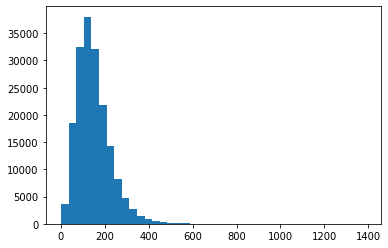

In [57]:
plt.hist(char_sentences_lenghts, bins=40);

In [58]:
char_vectorizer = TextVectorization(max_tokens=70,
                                         output_sequence_length=300,
                                         pad_to_max_tokens=True)
char_vectorizer.adapt(train_sentences_character)

In [59]:
char_vectorizer(train_sentences_character[20])

<tf.Tensor: shape=(300,), dtype=int64, numpy=
array([19,  2,  3,  5,  3,  3,  2,  6,  3,  4,  7,  6, 15,  5,  4,  6,  3,
        2,  6,  5,  6, 11,  2,  7,  6, 17,  7,  7, 10, 11, 16,  2,  9, 20,
        5,  9,  9,  4, 18,  6,  4, 17,  4, 11,  5,  6,  3, 12, 19,  8,  2,
       12,  5,  3,  2, 10,  3,  7,  4,  6, 11,  8,  2,  5,  9,  2, 10,  4,
        6,  3,  5, 23,  2,  9, 14,  2, 11,  4, 17,  4, 11,  5, 12, 12, 19,
        4,  6,  3, 13,  2,  6,  2, 16,  3,  8,  5, 12, 11,  7,  6, 10,  4,
        3,  4,  7,  6, 22, 16,  3,  6,  7,  3,  4,  6,  3, 13,  2,  9,  5,
       10, 15,  7,  7, 10, 11,  7,  6, 10,  4,  3,  4,  7,  6,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,

In [60]:
char_vocab = char_vectorizer.get_vocabulary()

In [61]:
char_vocab[:10]

['', '[UNK]', 'e', 't', 'i', 'a', 'n', 'o', 'r', 's']

In [62]:
train_char_prefetch = tf.data.Dataset.from_tensor_slices((train_sentences_character, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_prefetch = tf.data.Dataset.from_tensor_slices((val_sentences_character, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_prefetch = tf.data.Dataset.from_tensor_slices((test_sentences_character, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [63]:
char_embedding = Embedding(input_dim=len(char_vocab),
                           output_dim=64,
                           mask_zero=True,
                           input_length=300)

In [64]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = char_vectorizer(inputs)
x = char_embedding(x)
x = layers.Conv1D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv1D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Conv1D(32, 3, padding='same', activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(5, activation='softmax')(x)

model_4 = tf.keras.Model(inputs, outputs)
model_4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 300)              0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 300, 64)           1792      
                                                                 
 conv1d_10 (Conv1D)          (None, 300, 64)           12352     
                                                                 
 conv1d_11 (Conv1D)          (None, 300, 64)           12352     
                                                                 
 conv1d_12 (Conv1D)          (None, 300, 32)           6176      
                                                           

In [65]:
history_4 = model_4.fit(train_char_prefetch, steps_per_epoch=int(0.1*len(train_char_prefetch)), validation_data=val_char_prefetch, validation_steps=len(val_char_prefetch), epochs=5, callbacks=[create_tb_callback('model_4(character)', 'experiments')])

Epoch 1/5
562/562 [==============================] - 8s 12ms/step - loss: 1.3134 - accuracy: 0.4428 - val_loss: 1.1401 - val_accuracy: 0.5438
Epoch 2/5
562/562 [==============================] - 6s 11ms/step - loss: 1.0208 - accuracy: 0.5900 - val_loss: 0.9318 - val_accuracy: 0.6309
Epoch 3/5
562/562 [==============================] - 6s 11ms/step - loss: 0.9295 - accuracy: 0.6309 - val_loss: 0.8713 - val_accuracy: 0.6570
Epoch 4/5
562/562 [==============================] - 6s 11ms/step - loss: 0.8668 - accuracy: 0.6616 - val_loss: 0.8383 - val_accuracy: 0.6725
Epoch 5/5
562/562 [==============================] - 6s 11ms/step - loss: 0.8531 - accuracy: 0.6682 - val_loss: 0.8530 - val_accuracy: 0.6656


In [66]:
model_4_scores = classification_scores(val_labels_one_hot, tf.round(model_4.predict(val_char_prefetch)))
model_4_scores

Accuracy: 0.5356149874222164
Precision: 0.7856048354582538
Recall: 0.5356149874222164
F1_score: 0.6314873640158961


In [67]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = char_vectorizer(inputs)
x = char_embedding(x)
x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(32))(x)
outputs = layers.Dense(5, activation='softmax')(x)

model_5 = tf.keras.Model(inputs, outputs)
model_5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_5.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 300)              0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 300, 64)           1792      
                                                                 
 bidirectional (Bidirectiona  (None, 300, 64)          24832     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                           

In [68]:
history_5 = model_5.fit(train_char_prefetch, steps_per_epoch=int(0.1*len(train_char_prefetch)), validation_data=val_char_prefetch, validation_steps=len(val_char_prefetch), epochs=5, callbacks=[create_tb_callback('model_5(bidirectionalChar)', 'experiments')])

Epoch 1/5
562/562 [==============================] - 75s 107ms/step - loss: 1.2681 - accuracy: 0.4703 - val_loss: 1.1765 - val_accuracy: 0.5242
Epoch 2/5
562/562 [==============================] - 58s 103ms/step - loss: 1.1267 - accuracy: 0.5394 - val_loss: 1.0661 - val_accuracy: 0.5650
Epoch 3/5
562/562 [==============================] - 51s 91ms/step - loss: 1.0607 - accuracy: 0.5688 - val_loss: 1.0154 - val_accuracy: 0.5900
Epoch 4/5
562/562 [==============================] - 59s 104ms/step - loss: 0.9891 - accuracy: 0.6017 - val_loss: 0.9672 - val_accuracy: 0.6149
Epoch 5/5
562/562 [==============================] - 54s 95ms/step - loss: 0.9543 - accuracy: 0.6159 - val_loss: 0.9173 - val_accuracy: 0.6309


In [69]:
model_5_scores = classification_scores(val_labels_one_hot, tf.round(model_5.predict(val_char_prefetch)))
model_5_scores

Accuracy: 0.4845094664371773
Precision: 0.7535259501755669
Recall: 0.4845094664371773
F1_score: 0.5647066306682601


### Concatenating

In [70]:
token_inputs = layers.Input(shape=[], dtype=tf.string)
token_embeddings = encoder_layer(token_inputs)
token_outputs = layers.Dense(64, activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

char_inputs = layers.Input(shape=(1,), dtype=tf.string)
char_tokenizer = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_tokenizer)
char_outputs = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_outputs)

combined_input = layers.Concatenate()([token_model.output, char_model.output])
combined_dropout = layers.Dropout(0.3)(combined_input)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.2)(combined_dense)
outputs = layers.Dense(5, activation='softmax')(final_dropout)

model_6 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=outputs)

In [71]:
model_6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_6.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 300)         0           ['input_7[0][0]']                
 orization)                                                                                       
                                                                                                  
 keras_layer (KerasLayer)       (None, 512)          256797824   ['input_6[0][0]']          

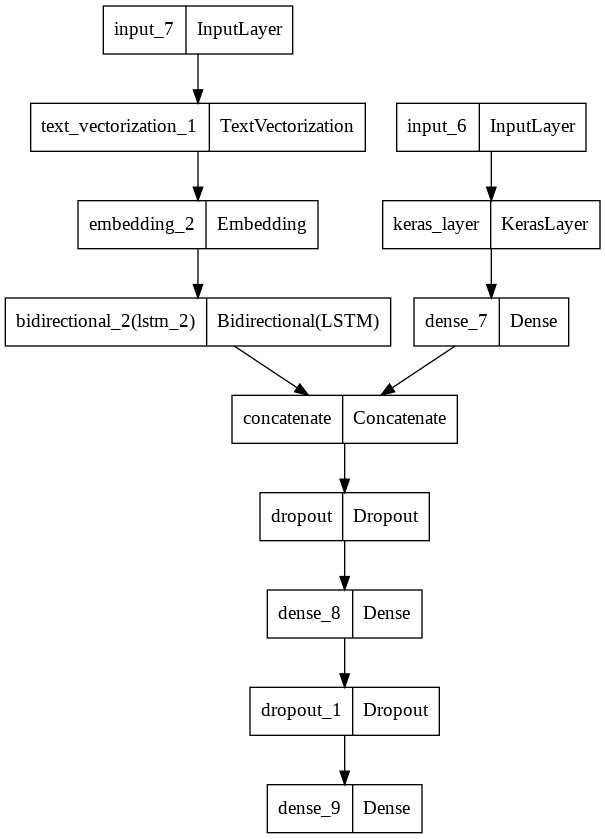

In [72]:
from tensorflow.keras.utils import plot_model

plot_model(model_6)

In [73]:
combined_train_dataset = tf.data.Dataset.from_tensor_slices(((train_sentences, train_sentences_character), train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
combined_val_dataset = tf.data.Dataset.from_tensor_slices(((val_sentences, val_sentences_character), val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
combined_test_dataset = tf.data.Dataset.from_tensor_slices(((test_sentences, test_sentences_character), test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [74]:
history_6 = model_6.fit(combined_train_dataset,
                        epochs=5,
                        validation_data=combined_val_dataset,
                        steps_per_epoch=int(0.1*len(combined_train_dataset)),
                        validation_steps=len(combined_val_dataset),
                        callbacks=[create_tb_callback('model_6(combined)', 'experiments')])

Epoch 1/5
562/562 [==============================] - 55s 84ms/step - loss: 0.9296 - accuracy: 0.6376 - val_loss: 0.7691 - val_accuracy: 0.7067
Epoch 2/5
562/562 [==============================] - 45s 80ms/step - loss: 0.7656 - accuracy: 0.7039 - val_loss: 0.7071 - val_accuracy: 0.7313
Epoch 3/5
562/562 [==============================] - 42s 75ms/step - loss: 0.7390 - accuracy: 0.7171 - val_loss: 0.6902 - val_accuracy: 0.7359
Epoch 4/5
562/562 [==============================] - 46s 81ms/step - loss: 0.7090 - accuracy: 0.7293 - val_loss: 0.6593 - val_accuracy: 0.7488
Epoch 5/5
562/562 [==============================] - 43s 77ms/step - loss: 0.7112 - accuracy: 0.7284 - val_loss: 0.6510 - val_accuracy: 0.7497


In [75]:
model_6_scores = classification_scores(val_labels_one_hot, tf.round(model_6.predict(combined_val_dataset)))
model_6_scores

Accuracy: 0.6872434794121541
Precision: 0.8012712797870349
Recall: 0.6872434794121541
F1_score: 0.728056177286683


### Position

In [76]:
train_df.head()

,id,line_number,target,text,total_lines
0,###24293578,0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,11
1,###24293578,1,METHODS,A total of @ patients with primary knee OA wer...,11
2,###24293578,2,METHODS,Outcome measures included pain reduction and i...,11
3,###24293578,3,METHODS,Pain was assessed using the visual analog pain...,11
4,###24293578,4,METHODS,Secondary outcome measures included the Wester...,11


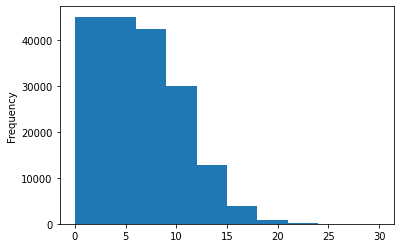

In [77]:
train_df.line_number.plot.hist()

In [78]:
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)
train_line_numbers_one_hot[30:60]

<tf.Tensor: shape=(30, 15), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0

In [79]:
train_tl_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_tl_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_tl_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)

In [80]:
tribrid_train_dataset = tf.data.Dataset.from_tensor_slices(((train_sentences, train_sentences_character, train_line_numbers_one_hot, train_tl_one_hot), train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
tribrid_val_dataset = tf.data.Dataset.from_tensor_slices(((val_sentences, val_sentences_character, val_line_numbers_one_hot, val_tl_one_hot), val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
tribrid_test_dataset = tf.data.Dataset.from_tensor_slices(((test_sentences, test_sentences_character, test_line_numbers_one_hot, test_tl_one_hot), test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [81]:
tribrid_train_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [82]:
token_inputs = layers.Input(shape=[], dtype=tf.string)
token_embeddings = encoder_layer(token_inputs)
token_outputs = layers.Dense(64, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)


char_inputs = layers.Input(shape=(1,), dtype=tf.string)
char_tokens = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_tokens)
char_bidirectional = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bidirectional)


line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32)
line_number_dense = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=line_number_dense)

total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32)
total_lines_dense = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=total_lines_dense)

combined_embeddings = layers.Concatenate()([token_model.output, 
                                            char_model.output])
comb_dense = layers.Dense(128, activation="relu")(combined_embeddings)
comb_dropout = layers.Dropout(0.3)(comb_dense)

tribrid = layers.Concatenate()([line_number_model.output,
                                total_lines_model.output,
                                comb_dropout])

output_layer = layers.Dense(5, activation="softmax")(tribrid)

model_7 = tf.keras.Model(inputs=[token_model.input,
                                 char_model.input,
                                 line_number_model.input,
                                 total_lines_model.input],
                                 outputs=output_layer)

In [83]:
model_7.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), 
                optimizer='adam', 
                metrics=['accuracy'])
model_7.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 300)         0           ['input_9[0][0]']                
 orization)                                                                                       
                                                                                                  
 keras_layer (KerasLayer)       (None, 512)          256797824   ['input_8[0][0]']         

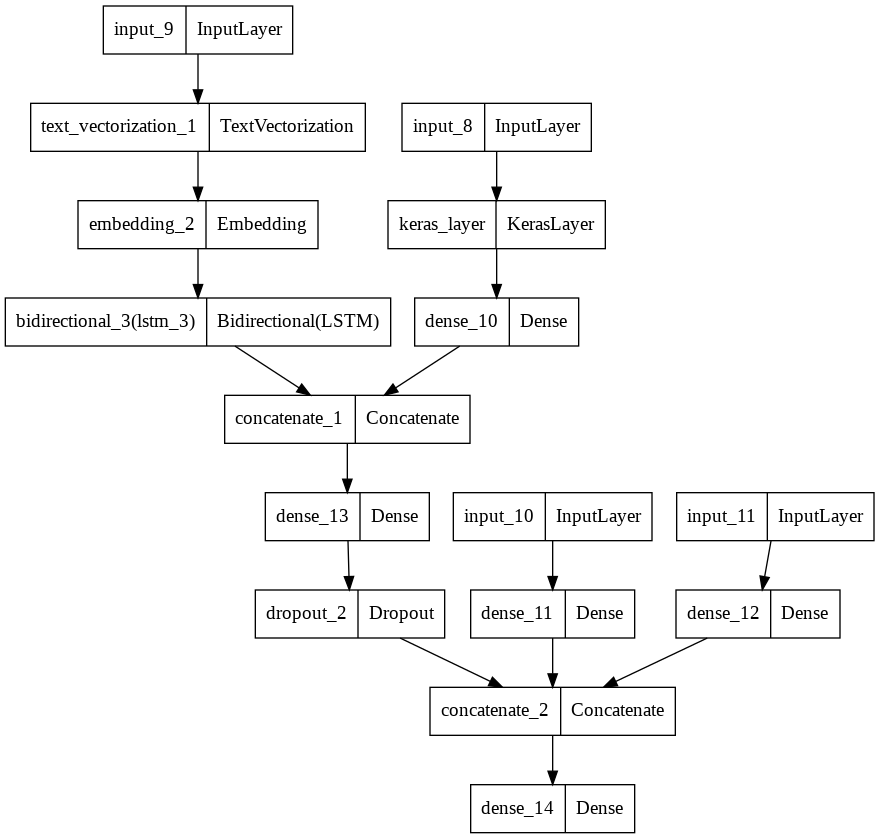

In [84]:
plot_model(model_7)

In [85]:
history_7 = model_7.fit(tribrid_train_dataset, epochs=5, steps_per_epoch=int(0.1*len(tribrid_train_dataset)), validation_data=tribrid_val_dataset, validation_steps=int(0.1*len(tribrid_val_dataset)), callbacks=[create_tb_callback('tribrid', 'experiments')])

Epoch 1/5
562/562 [==============================] - 38s 54ms/step - loss: 1.0950 - accuracy: 0.7258 - val_loss: 0.9854 - val_accuracy: 0.7989
Epoch 2/5
562/562 [==============================] - 28s 50ms/step - loss: 0.9675 - accuracy: 0.8129 - val_loss: 0.9503 - val_accuracy: 0.8238
Epoch 3/5
562/562 [==============================] - 25s 44ms/step - loss: 0.9501 - accuracy: 0.8215 - val_loss: 0.9400 - val_accuracy: 0.8261
Epoch 4/5
562/562 [==============================] - 29s 51ms/step - loss: 0.9392 - accuracy: 0.8355 - val_loss: 0.9313 - val_accuracy: 0.8305
Epoch 5/5
562/562 [==============================] - 27s 47ms/step - loss: 0.9373 - accuracy: 0.8352 - val_loss: 0.9275 - val_accuracy: 0.8378


In [86]:
model_7_scores = classification_scores(val_labels_one_hot, tf.round(model_7.predict(tribrid_val_dataset)))

Accuracy: 0.7464583609161922
Precision: 0.8941362516885363
Recall: 0.7464583609161922
F1_score: 0.8069727433242547


# Final model (200k)

In [87]:
import zipfile
zip_ref = zipfile.ZipFile('/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip')
zip_ref.extractall()
zip_ref.close()

In [88]:

training_set_full = preprocess_abstracts('/content/train.txt')
test_set_full = preprocess_abstracts('/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/test.txt')
val_set_full = preprocess_abstracts('/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/dev.txt')

train_df = pd.DataFrame(training_set_full)
val_df = pd.DataFrame(val_set_full)
test_df = pd.DataFrame(test_set_full)

one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = tf.constant(one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1)))
val_labels_one_hot = tf.constant(one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1)))
test_labels_one_hot = tf.constant(one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1)))

train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

train_sentences_character = [splitchar(text) for text in train_sentences]
test_sentences_character = [splitchar(text) for text in test_sentences]
val_sentences_character = [splitchar(text) for text in val_sentences]

train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)

train_tl_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_tl_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_tl_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)

tribrid_train_dataset_full = tf.data.Dataset.from_tensor_slices(((train_sentences, train_sentences_character, train_line_numbers_one_hot, train_tl_one_hot), train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
tribrid_val_dataset_full = tf.data.Dataset.from_tensor_slices(((val_sentences, val_sentences_character, val_line_numbers_one_hot, val_tl_one_hot), val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
tribrid_test_dataset_full = tf.data.Dataset.from_tensor_slices(((test_sentences, test_sentences_character, test_line_numbers_one_hot, test_tl_one_hot), test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [89]:
token_inputs = layers.Input(shape=[], dtype=tf.string)
token_embeddings = encoder_layer(token_inputs)
token_outputs = layers.Dense(64, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)


char_inputs = layers.Input(shape=(1,), dtype=tf.string)
char_tokens = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_tokens)
char_bidirectional = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bidirectional)


line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32)
line_number_dense = layers.Dense(64, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=line_number_dense)

total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32)
total_lines_dense = layers.Dense(64, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=total_lines_dense)

combined_embeddings = layers.Concatenate()([token_model.output, 
                                            char_model.output])
comb_dense = layers.Dense(128, activation="relu")(combined_embeddings)
comb_dropout = layers.Dropout(0.3)(comb_dense)

tribrid = layers.Concatenate()([line_number_model.output,
                                total_lines_model.output,
                                comb_dropout])
tribrid_dense = layers.Dense(128, activation='relu')(tribrid)
tribrid_dropout = layers.Dropout(0.3)(tribrid_dense)
output_layer = layers.Dense(5, activation="softmax")(tribrid_dropout)

final_model = tf.keras.Model(inputs=[token_model.input,
                                 char_model.input,
                                 line_number_model.input,
                                 total_lines_model.input],
                                 outputs=output_layer)
final_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), 
                optimizer='adam', 
                metrics=['accuracy'])

In [90]:
history_8 = final_model.fit(tribrid_train_dataset_full, epochs=5, steps_per_epoch=len(tribrid_train_dataset_full), validation_data=tribrid_val_dataset_full, validation_steps=int(0.1*len(tribrid_val_dataset)), callbacks=[create_tb_callback('final_model', 'experiments')])

Epoch 1/5
69121/69121 [==============================] - 3069s 44ms/step - loss: 0.8657 - accuracy: 0.8725 - val_loss: 0.8287 - val_accuracy: 0.8880
Epoch 2/5
69121/69121 [==============================] - 3019s 44ms/step - loss: 0.8471 - accuracy: 0.8850 - val_loss: 0.8244 - val_accuracy: 0.8893
Epoch 3/5
69121/69121 [==============================] - 3011s 44ms/step - loss: 0.8426 - accuracy: 0.8880 - val_loss: 0.8227 - val_accuracy: 0.8933
Epoch 4/5
69121/69121 [==============================] - 3024s 44ms/step - loss: 0.8403 - accuracy: 0.8895 - val_loss: 0.8200 - val_accuracy: 0.8943
Epoch 5/5
69121/69121 [==============================] - 3103s 45ms/step - loss: 0.8386 - accuracy: 0.8907 - val_loss: 0.8199 - val_accuracy: 0.8983


In [ ]:
final_model_scores = classification_scores(val_labels_one_hot, tf.round(final_model.predict(tribrid_val_dataset_full)))

In [ ]:
test_scores = classification_scores(test_labels_one_hot, tf.round(final_model.predict(tribrid_test_dataset_full)))

In [ ]:
test_scores

In [ ]:
plot_loss_curves(history_8)

In [ ]:
final_model.save('SkimLit.h5')

In [ ]:
from google.colab import files
files.download('SkimLit.h5')